In [22]:
import keras

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Activation
%matplotlib inline

In [25]:
X=pd.read_csv("./street_light_dummy_data.csv")

In [26]:
X=X.dropna(axis=1)

In [ ]:
X=X.drop(labels=['cycle'],axis=1)

In [27]:
X.head(5)

,id,cycle,I(Amps),V(Volts),Units(Kwh),Photosensor,Temp.,RUL,cycle_norm
0,1,1,0.183735,0.406802,0.309757,0.333333,0.713178,191,0.00000
1,1,2,0.283133,0.453019,0.352633,0.333333,0.666667,190,0.00277
2,1,3,0.343373,0.369523,0.370527,0.166667,0.627907,189,0.00554
3,1,4,0.343373,0.256159,0.331195,0.333333,0.573643,188,0.00831
4,1,5,0.349398,0.257467,0.404625,0.416667,0.589147,187,0.01108


In [28]:
X.columns

Index(['id', 'cycle', 'I(Amps)', 'V(Volts)', 'Units(Kwh)', 'Photosensor',
       'Temp.', 'RUL', 'cycle_norm'],
      dtype='object')

In [29]:
sequence_length = 2

In [30]:
def gen_sequence(id_df, seq_length, seq_cols):
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_array[start:stop, :]

In [31]:
sequence_cols=['I(Amps)', 'V(Volts)', 'Units(Kwh)', 'Photosensor',
       'Temp.', 'cycle_norm']

In [32]:
seq_gen = (list(gen_sequence(X[X['id']==id], sequence_length, sequence_cols)) 
           for id in X['id'].unique())

In [33]:
seq_array = np.concatenate(list(seq_gen)).astype(np.float32)

seq_array.shape

(20431, 2, 6)

In [34]:
def gen_labels(id_df, seq_length, label):
    data_array = id_df[label].values
    num_elements = data_array.shape[0]
    return data_array[seq_length:num_elements, :]

In [35]:
label_gen = [gen_labels(X[X['id']==id], sequence_length, ['RUL']) 
             for id in X['id'].unique()]
label_array = np.concatenate(label_gen).astype(np.float32)
label_array.shape

(20431, 1)

In [36]:
nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]

model = Sequential()

model.add(LSTM(
         input_shape=(2,6),
         units=100
         ))
model.add(Dropout(0.2))
model.add(LSTM(
         units=50
         ))
model.add(Dropout(0.2))
model.add(Dense(units=20,activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(units=1))
model.compile(loss='mae', optimizer='adam')

Instructions for updating:
Colocations handled automatically by placer.


In [37]:
model.fit(seq_array, label_array, epochs=50, batch_size=50, verbose=1, shuffle=True)

Instructions for updating:
Use tf.cast instead.
Epoch 1/50
20431/20431 [==============================] - 8s 376us/step - loss: 82.3212
Epoch 2/50
20431/20431 [==============================] - 2s 108us/step - loss: 62.3869
Epoch 3/50
20431/20431 [==============================] - 2s 107us/step - loss: 57.5502
Epoch 4/50
20431/20431 [==============================] - 2s 107us/step - loss: 56.4912
Epoch 5/50
20431/20431 [==============================] - 2s 107us/step - loss: 55.8102
Epoch 6/50
20431/20431 [==============================] - 2s 107us/step - loss: 38.0713
Epoch 7/50
20431/20431 [==============================] - 2s 106us/step - loss: 31.2304
Epoch 8/50
20431/20431 [==============================] - 2s 107us/step - loss: 29.7510
Epoch 9/50
20431/20431 [==============================] - 2s 107us/step - loss: 29.0299
Epoch 10/50
20431/20431 [==============================] - 2s 106us/step - loss: 28.5891
Epoch 11/50
20431/20431 [==============================] - 2s 107us/ste

In [ ]:
a=X[['I(Amps)', 'V(Volts)', 'Units(Kwh)', 'Photosensor',
       'Temp.', 'cycle_norm']]

In [33]:
seq_array[2]

array([[0.3433735 , 0.36952257, 0.37052667, 0.16666667, 0.627907  ,
        0.00554017],
       [0.3433735 , 0.2561587 , 0.33119515, 0.33333334, 0.5736434 ,
        0.00831025]], dtype=float32)

In [43]:
z=model.predict(seq_array[100:900])

In [45]:
a=pd.DataFrame(z)

In [46]:
a.to_csv("./predicted.csv")

In [56]:
pd.DataFrame(z).max()

0    208.866989
dtype: float32

In [ ]:
from sklearn.ensemble import RandomForestRegressor
reg=RandomForestRegressor()

In [ ]:
reg.fit(X.drop(labels=['RUL'],axis=1),X['RUL'])

In [ ]:
reg.score(X.drop(labels=['RUL'],axis=1),X['RUL'])

In [ ]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
 

In [ ]:
reframed = series_to_supervised(X.values, 2, 1)

In [ ]:
col=X.columns.tolist()

In [ ]:
col

In [ ]:
col = ['id',
 'I(Amps)',
 'V(Volts)',
 'Units(Kwh)',
 'Photosensor',
 'Temp.',
 'cycle_norm','RUL']

In [ ]:
X=X[col]

In [ ]:
X.head(5)

In [ ]:
reframed

In [ ]:
values = reframed.values

train_X, train_y = values[:, :-1], values[:, -1]

In [ ]:
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))

In [ ]:
m=pd.DataFrame(model.predict(train_X[:2].reshape((2,1,23)).astype(np.int)))

In [7]:
X.shape

(20631, 9)

In [8]:
X.columns

Index(['id', 'cycle', 'I(Amps)', 'V(Volts)', 'Units(Kwh)', 'Photosensor',
       'Temp.', 'RUL', 'cycle_norm'],
      dtype='object')

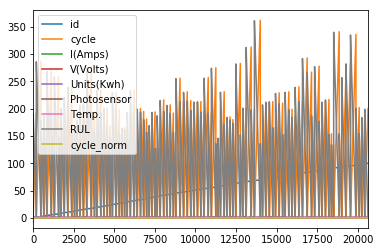

In [10]:
X.plot()

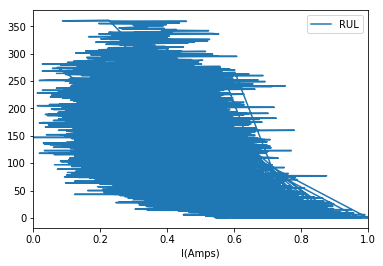

In [12]:
X.plot(x='I(Amps)',y='RUL')

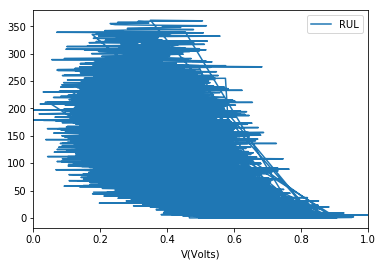

In [14]:
X.plot(x='V(Volts)',y='RUL')

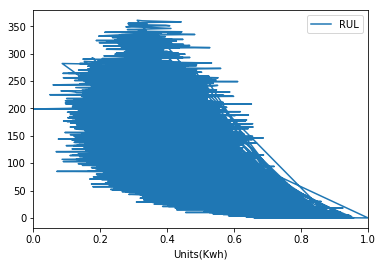

In [15]:
X.plot(x='Units(Kwh)',y='RUL')

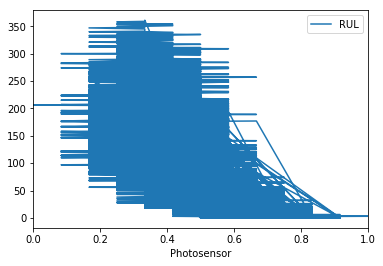

In [17]:
X.plot(x='Photosensor',y='RUL')

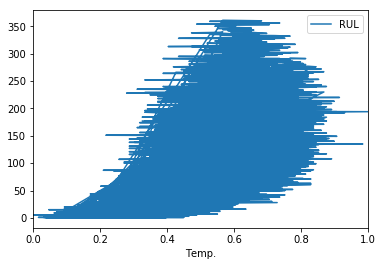

In [18]:
X.plot(x='Temp.',y='RUL')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000231D7D7E1D0>,
      dtype=object)

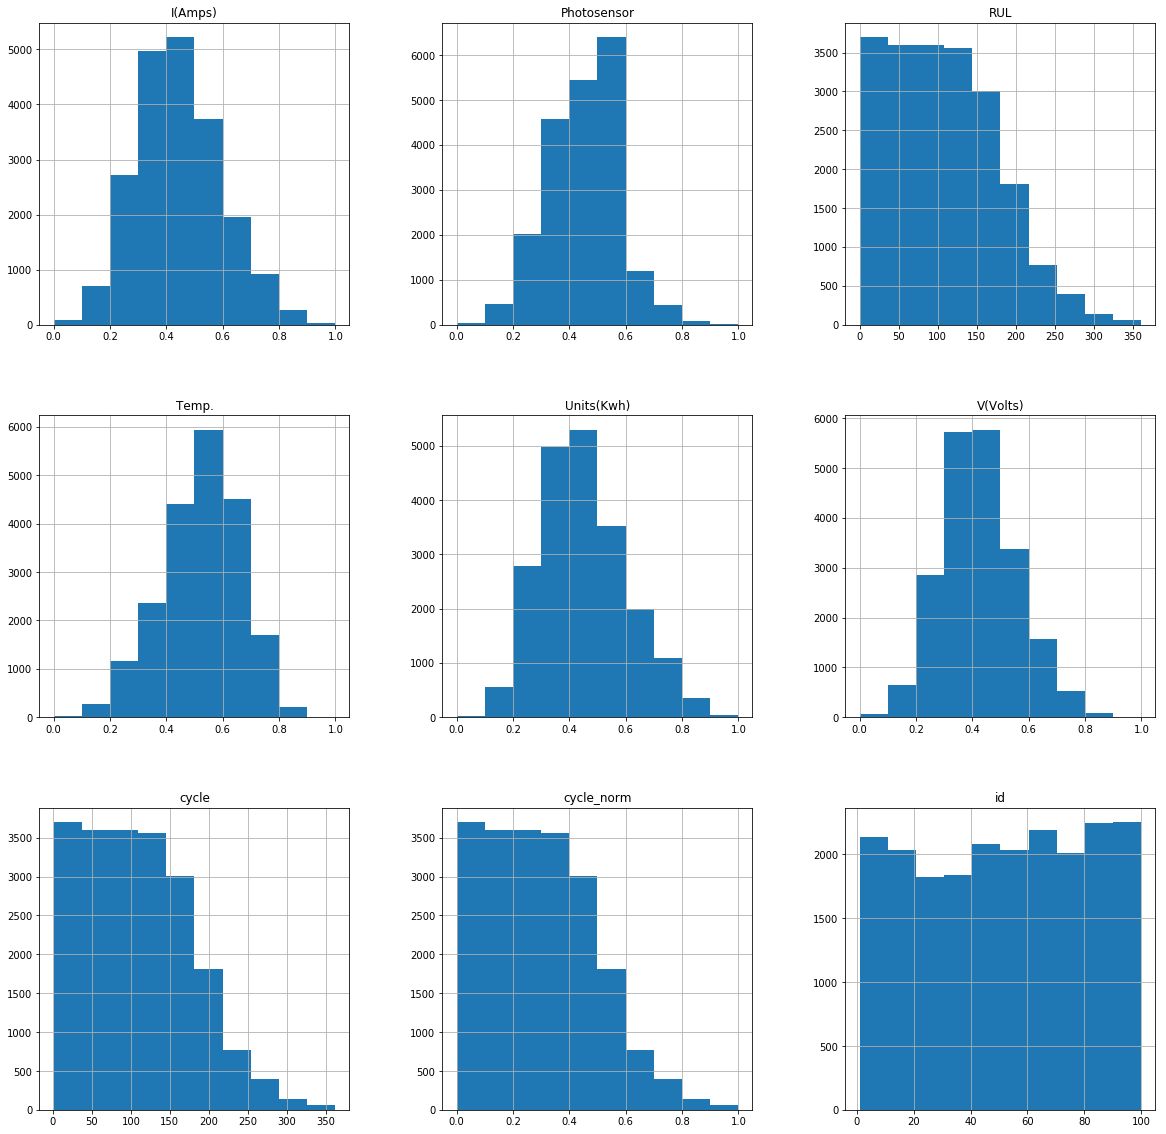

In [20]:
X.hist(figsize=(20,20))